#W207 Machine Learning Final Project #
###Forest Cover Type Prediction###
Amitava Das & Katherine Shelley

###Data Dictionary###

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for cleaning/feature selection
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV

#classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

#metrics/cross-validation
from sklearn.cross_validation import cross_val_score

In [2]:
np.random.seed(0)

##Part 1: Data Collection and Baseline Estimation##
First we will download the data and split it into a training, development, and test sets.

###Load the data###
First let's load the data into a Pandas dataframe. The data has a lot of dummy binary features, which means there will be a lot of entries that are zero and we'll be adding more binary features to the data set. We will use a sparse representation in both Pandas and Numpy to save space and reduce computation time on the test set. Read more about Pandas sparse representation here: http://pandas.pydata.org/pandas-docs/stable/sparse.html and Numpy Column Sparse Row (CSR) matrices here: http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix

df_train type: <class 'pandas.core.frame.DataFrame'>
Training set shape (15120, 54)

df_test type: <class 'pandas.sparse.frame.SparseDataFrame'>
Test set shape (565892, 54)


(array([ 2160.,  2160.,     0.,  2160.,     0.,  2160.,  2160.,     0.,
         2160.,  2160.]),
 array([ 1. ,  1.6,  2.2,  2.8,  3.4,  4. ,  4.6,  5.2,  5.8,  6.4,  7. ]),
 <a list of 10 Patch objects>)

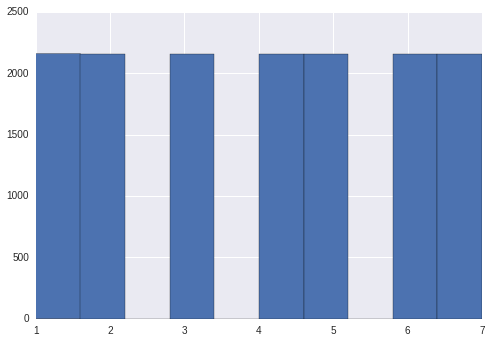

In [3]:
#read the training data into a pandas dataframe
data = os.path.join(os.getcwd(),'train.csv')
df_train = pd.read_csv(data)

#read the test data into a pandas frame
data = os.path.join(os.getcwd(),'test.csv')
df_test = pd.read_csv(data).to_sparse()

#use pandas column features to select only the feature columns so we can remove the IDs
features = [col for col in df_train.columns if col not in ['Cover_Type','Id']]

df_train_labels = df_train['Cover_Type']
df_train = df_train[features]

test_ids = df_test['Id']
df_test = df_test[features]


#You can see we have loaded the test data into a sparse dataframe
print 'df_train type: %s' % type(df_train)
print 'Training set shape %s' % str(df_train.shape)
print
print 'df_test type: %s' % type(df_test)
print 'Test set shape %s' % str(df_test.shape)

#let's take a look at the range of labels we have
plt.hist(df_train_labels.as_matrix())

###Baseline model###
We will initially create a baseline model using the K-Nearest Neighbors classifier with n_neighbors set to 1. 

In [4]:
#We will use this generic function for outputting Kaggle submission CSV files based
#on a classifier and training data we define
def print_out_kaggle_submission(clf,train_dat,train_lab,test_dat,ids):
    clf.fit(train_dat,train_lab)
    predicted = clf.predict(test_dat)
    outfile = zip(ids, predicted)
    np.savetxt("Submission.csv", outfile, fmt='%i', delimiter=',', newline='\n', header='Id,Cover_Type',comments='')
    print "Saved ", len(outfile),"records to Submission.csv"
    plt.hist(predicted)

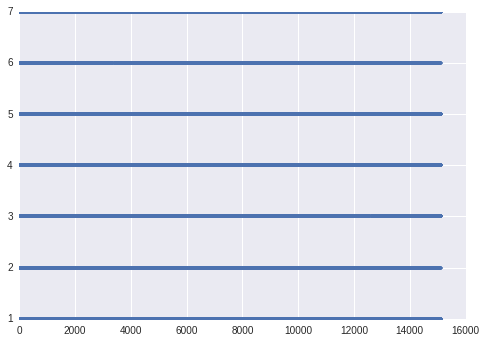

In [5]:
X = np.array(df_train)
Y = np.array(df_train_labels)
test_data = csr_matrix(np.array(df_test))

shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

plt.plot(range(X.shape[0]),Y,".") #plot the occurence of each target to ensure we have a good random mix

Saved  565892 records to Submission.csv


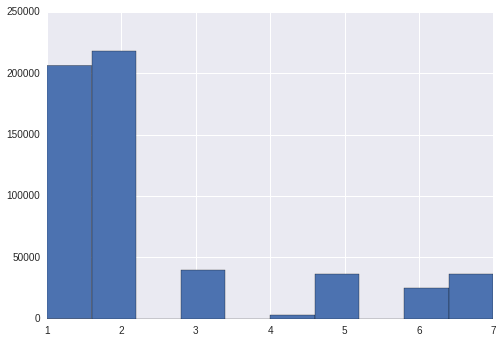

In [15]:
knn = KNeighborsClassifier(n_neighbors=1)
print_out_kaggle_submission(knn,X,Y,test_data.todense(),test_ids)

With this baseline we were able to obtain an accuracy of **71.06%** against the test set.

##Part 2: Exploring Different Models##
Next we will use Grid Search to analyze various models to see if we get improvement simply by switching from Nearest Neighbors.

In [6]:
# Set some variables to hold dev and training data;
N = X.shape[0]
dev_data, dev_labels = X[2*N/3:], Y[2*N/3:]
train_data, train_labels = X[:2*N/3], Y[:2*N/3]

print "Training data: %s" % str(train_data.shape)
print "Development data: %s" % str(dev_data.shape)

Training data: (10080, 54)
Development data: (5040, 54)


###Logistic Regression###
Let's see if we can do better with Logistic Regression. Logistic Regression is a popular choice for classification because it scales well to large datasets and because of it's probabalistic interpretation.

In [7]:
lm = LogisticRegression(C=0.1) #initialize a logistic regression model
lm.fit(train_data,train_labels)
print 'Logistic Regression give %s Accuracy using C = 0.1' % (lm.score(dev_data,dev_labels)*100)

Logistic Regression give 66.9444444444 Accuracy using C = 0.1


###Random Forests###
Now Let's test a Random Forest with a large number of trees. Decision trees and random forests are a good tool because they generally build models that can be explicitly understood and explained, and they create non-linear decision boundaries. 

In [18]:
rf = RandomForestClassifier(n_estimators=25)
rf.fit(train_data,train_labels)
print 'Random Forest gives %s percent Accuracy using 25 trees' % (rf.score(dev_data,dev_labels)*100)

Random Forest gives 84.2857142857 percent Accuracy using 25 trees


Random forests have given by far the best accuracy that we have seen. Let's now evaluate this model.

##Part 3: Evaluating Our Model##
Next we will analyze the accuracy of our chosen model and explore feature engineering and dimensionality reduction to try to improve the accuracy of our Random Forest classifier.

###Bias/Variance Analysis###
A **high bias** model is one that is not affected strongly by changes to the training data; in other words the error rate between the training and development sets are similar, but shows a high amount of error against the test set. Namely it is a model that is **underfit**. A **high variance** model is one that is sensitive to changes in the training data and shows little to no error, however returns a high amount of error against the development and test sets; namely, an **overfit** model. 

Underfit and overfit models should be dealt with in very different ways when it comes to feature engineering, so before we can determine the steps we should take to improve our model's accuracy we need to understand if the baseline Random Forest is displaying high bias or high variance. To do this, let's run the model with various amounts of estimators and compare the error rate of the model on the training set versus our development set.

In [6]:
#Let's define a simple error rate function; concretely, the average percentage of predictions that are wrong.
def error_rate(clf,X,y):
    return 1.0/(X.shape[0])*np.sum(np.where(y<>clf.predict(X),np.ones(X.shape[0]),np.zeros(X.shape[0])))

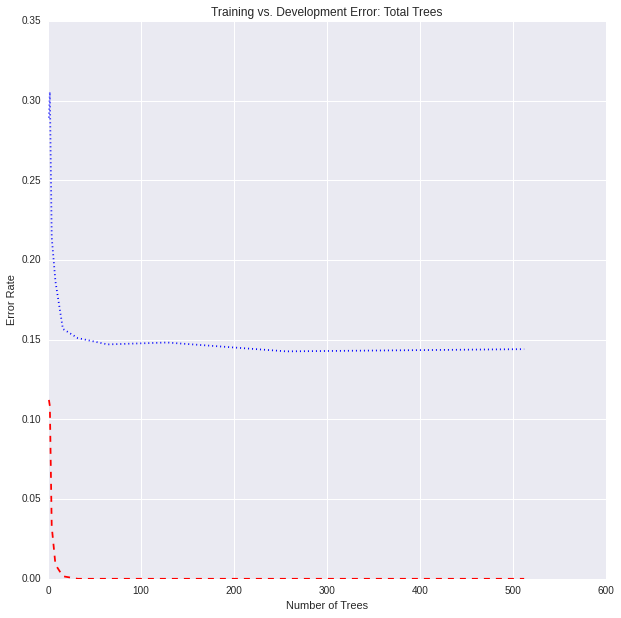

In [20]:
#iterate through several sizes of forest classifiers, 
#and plot the error rate of the training prediction vs. 
#the development prediction.
trees=[2**i for i in range(10)]
train_acc = []
dev_acc = []
for tree in trees:
    rf = RandomForestClassifier(n_estimators=tree)
    rf.fit(train_data,train_labels)
    train_acc.append(error_rate(rf,train_data,train_labels))
    dev_acc.append(error_rate(rf,dev_data,dev_labels))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(trees,train_acc,'--',c='r')
ax.plot(trees,dev_acc,':',c='b')
ax.set_ylabel("Error Rate")
ax.set_xlabel("Number of Trees")
ax.set_title("Training vs. Development Error: Total Trees")


The large gap in the error rate between the development set and the training set, along with the fact that the error rate on the training set essentially drops to 0 as the number of trees increases above 100 tells us that our model as it stands now is high variance and is overfitted. It turns out that trimming the number of features, and engineering new, more generic features does little to help the fit of the random forest model. This is due to the very small training data size versus the test data.

Next let's look at the effect of reducing the size of each tree. We will again compare the error rates of the training set against the development set, but this time we'll run for various sizes of each tree.

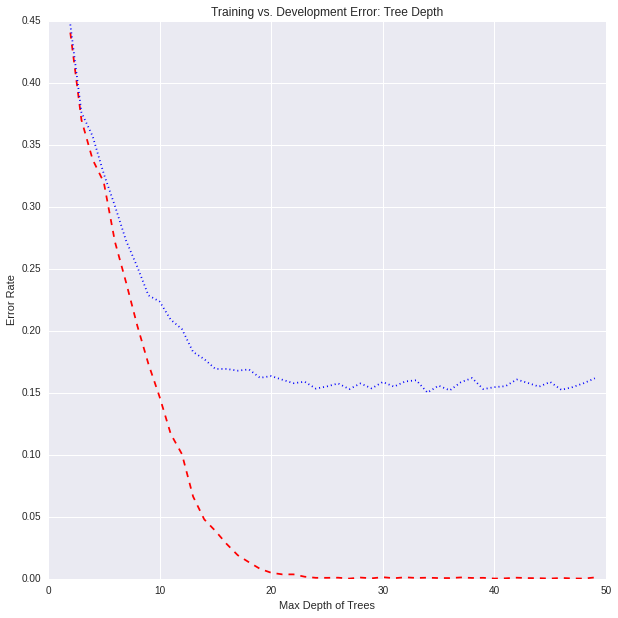

In [21]:
#iterate through several numbers of levels, 
#and plot the error rate of the training prediction vs. 
#the development prediction.
levels = range(2,50,1)
train_acc = []
dev_acc = []
for level in levels:
    rf = RandomForestClassifier(n_estimators=25,max_depth=level)
    rf.fit(train_data,train_labels)
    train_acc.append(error_rate(rf,train_data,train_labels))
    dev_acc.append(error_rate(rf,dev_data,dev_labels))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(range(2,50,1),train_acc,'--',c='r')
ax.plot(range(2,50,1),dev_acc,':',c='b')
ax.set_ylabel("Error Rate")
ax.set_xlabel("Max Depth of Trees")
ax.set_title("Training vs. Development Error: Tree Depth")


Another parameter we can analyze for our Random Forest is the minimum number of samples required for a node split. Again let's compare error rates of the training versus development set for various values of our minimum split parameter:

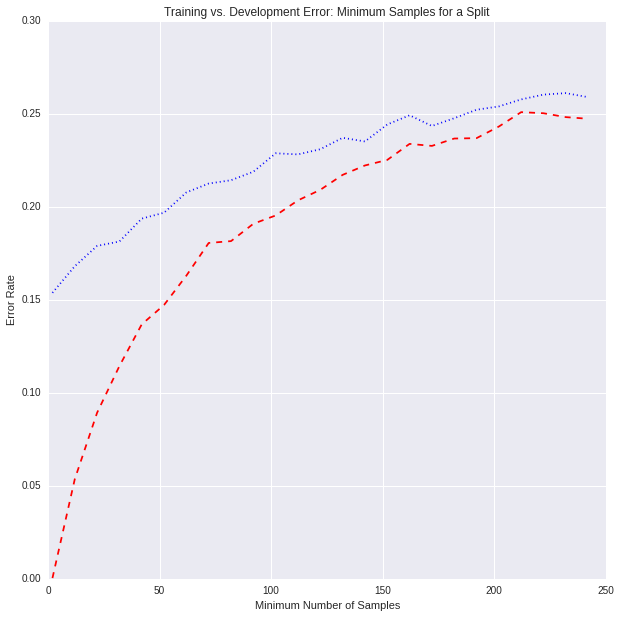

In [43]:
#iterate through several numbers of split parameters, 
#and plot the error rate of the training prediction vs. 
#the development prediction.

train_acc = []
dev_acc = []
for n in range(2,250,10):
    rf = RandomForestClassifier(n_estimators=25,min_samples_split=n)
    rf.fit(train_data,train_labels)
    train_acc.append(error_rate(rf,train_data,train_labels))
    dev_acc.append(error_rate(rf,dev_data,dev_labels))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(range(2,250,10),train_acc,'--',c='r')
ax.plot(range(2,250,10),dev_acc,':',c='b')
ax.set_ylabel("Error Rate")
ax.set_xlabel("Minimum Number of Samples")
ax.set_title("Training vs. Development Error: Minimum Samples for a Split")


We can see in the above graphs that leaving the RandomForestClassifier to split the data unbounded is leading us into the high-variance, over-fitted region that we do not want to be in. We can get less variance by adding more training examples, however that is not a choice that we have with a Kaggle competition. 

Our best choice moving forward is to work to reduce the variance using regularization options available for Random Forest models. Since overfitting in a random forest occurs when there is a leaf for every example, regularization of a random forest amounts to restricting the size of the tree. Let's run some comparisons on our test data restricting the number of levels each tree can reach and the minimum number of nodes required for a split, both parameters are the Decision Tree method of regularization. 

Due to the small training data set size we will use sci-kit learn's cross validation library to run a 5-fold cross validation on our fit model. You can read more about cross validation here: http://scikit-learn.org/stable/modules/cross_validation.html

In [68]:
#Let's check an anticipated accuracy using 5-fold cross-validation
rf = RandomForestClassifier(n_estimators=25,min_samples_split=20)
rf.fit(X,Y)
print 'Average accuracy: %s' % (np.mean(cross_val_score(rf,X,Y,cv=5))*100)

Average accuracy: 83.1415343915


Saved  565892 records to Submission.csv


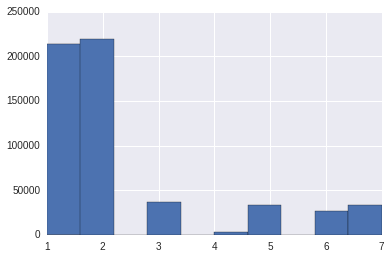

In [67]:
rf = RandomForestClassifier(n_estimators=25,min_samples_split=20)
print_out_kaggle_submission(rf,X,Y,test_data,test_ids)

By adding a minimum samples parameter we acheived accuracy of **70.17%** on the Kaggle test set.

##Part 4: Engineering and Tuning our Model##
Now that we've adjusted the Random Forest to be a more biased model we will work on improving the feature space. 

##Adding new features##
A first option to reduce bias in a model is to add new features that represent relationships the Random Forest can not extract by itself. Here is what we will do to add new features:
1. Add generic soil type fields based on the specific soil type fields available in the baseline data. Namely, we will pull out the first two soild ID prefix values as the last two values are merely for identification purposes.
2. Add binary fields for each climatic zone that is represented: lower montane dry, lower montane, montane dry, montane, subalpine, and alpine. Note that some records consist of multiple climatic zones.
3. We will add binary features for the Aspect field, truncating the aspect degrees into 90 degree quadrants.
4. We will engineer some of the existing features such as scaling the shade value fields to be between 0 and 1, convert degree fields to radians, and combine the two distance to hydrology features into a single, 3D distance field.

In [7]:
#Functions for feature engineering
def add_soil_prefix_fields(df):
    #adds new variables to a dataframe that represent the climatic and geologic zones 
    #(first two digits of the soil type variable)
    #we'll use a dicitonary to isolate the soil id's by their climatic/geologic prefix
    soil_id = {'27':['1','2','3','4','5','6'],
               '35':['7','8'],
               '42':['9'],
               '47':['10','11','12','13'],
               '51':['14','15'],
               '61':['16','17'],
               '67':['18'],
               '71':['19','20','21'],
               '72':['22','23'],
               '77':['24','25','26','27','28','29','30','31','32','33','34'],
               '87':['35','36','37','38','39','40']
              }

    climatic = {'2':['1','2','3','4','5','6'],
                '3':['7','8'],
               '4':['9','10','11','12','13'],
               '5':['14','15'],
               '6':['16','17','18'],
               '7':['19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34'],
               '8':['35','36','37','38','39','40']
               }

    geologic = {'1':['14','15','16','17','19','20','21'],
                '2':['9','22','23'],
                '5':['7','8'],
                '7':['1','2','3','4','5','6','10','11','12','13','18','24','25','26','27','28',
                     '29','30','31','32','33','34','35','36','37','38','39','40']
               }

    #add new variables for the soil type prefix, climatic zone, and geologic zone
    for key in soil_id:
        clim,geol = key[0],key[1]
        df_clim_geol = df[['Soil_Type%s' % i for i in soil_id[key]]] #soil type dual prefixes
        df_clim = df[['Soil_Type%s' % i for i in climatic[clim]]] #subset of df of climatic types
        df_geol = df[['Soil_Type%s' % i for i in geologic[geol]]] #subset of df of climatic types
        
        df['soil prefix %s' % key] = np.sum(np.asarray(df_clim_geol),axis=1)
        df['climatic zone %s' % clim] = np.sum(np.asarray(df_clim),axis=1)
        df['geologic zone %s' % geol] = np.sum(np.asarray(df_geol),axis=1)
        del df_clim_geol
        del df_clim
        del df_geol
    #df = df.drop([col for col in df.columns if col[:9]=='Soil_Type'],1)#drop the soil type fields
    return df

def generic_climatic(df):
    climatic = {'lower montane':['1','2'],
                'montane':['3','4','5','6'],
               'subalpine':['6','7'],
               'alpine':['8'],
               }
    for key in climatic:
        fields = ['climatic zone %s' % clim for clim in climatic[key] if 'climatic zone %s' % clim in df]
        df_climate = df[fields]
        df['%s zone' % key] = np.sum(np.asarray(df_climate),axis=1)
        del df_climate
    return df
    
def degrees_to_radians(df):
    for col in ['Aspect','Slope']:
        df[col] = np.radians(df[col].as_matrix())
    return df

def add_aspect_quadrants(df):
    df['Aspect0_90'] = np.where(df['Aspect']<0.5,np.ones(df.shape[0]),np.zeros(df.shape[0]))
    df['Aspect90_180'] = np.where(df['Aspect']<1,np.ones(df.shape[0]),np.zeros(df.shape[0])) - np.array(df['Aspect0_90'])
    df['Aspect180_270'] = np.where(df['Aspect']<1.5,np.ones(df.shape[0]),np.zeros(df.shape[0])) - np.array(df['Aspect0_90'] + df['Aspect90_180'])
    df['Aspect270_360'] = np.where(df['Aspect']>=1.5,np.ones(df.shape[0]),np.zeros(df.shape[0]))
    #df = df.drop('Aspect',1)#drop the aspect column
    return df

def scale_shade_value(df):
    for col in ['Hillshade_9am','Hillshade_Noon','Hillshade_3pm']:
        df[col] = df[col]*(1.0/255)
    return df

def total_dist_to_hydro(df):
    df['Total Distance to Hydrology'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)
    return df

#add fields for the soil type climatic and geologic zone prefixes
df_train = add_soil_prefix_fields(df_train)
df_train = generic_climatic(df_train)
df_train = degrees_to_radians(df_train)
df_train = add_aspect_quadrants(df_train)
df_train = scale_shade_value(df_train)
df_train = total_dist_to_hydro(df_train)

df_test = add_soil_prefix_fields(df_test)
df_test = generic_climatic(df_test)
df_test = degrees_to_radians(df_test)
df_test = add_aspect_quadrants(df_test)
df_test = scale_shade_value(df_test)
df_test = total_dist_to_hydro(df_test)


print df_train.shape
print df_test.shape

(15120, 85)
(565892, 85)


In [8]:
#reassign the X, Y and test arrays with the newly formed dataframes
X = np.array(df_train)
Y = np.array(df_train_labels) 
test_data = csr_matrix(np.array(df_test))

shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

In [71]:
#Let's check an anticipated accuracy using 5-fold cross-validation
rf = RandomForestClassifier(n_estimators=25,min_samples_split=20)
rf.fit(X,Y)
print 'Average accuracy: %s' % (np.mean(cross_val_score(rf,X,Y,cv=5))*100)

Average accuracy: 81.335978836


###Manipulating the Feature Space###
Now that we have a larger feature space, let's try some additional experiments that involve reducing the features in our model:
1. Scale the real valued features
4. Determine the top N features that the forest returns and look to scale down.

###Isolating the real-valued and binary features###

In [9]:
def scale_values(df_train,df_train_labels,df_test):
    #scales real-valued features
    real_valued = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
           'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
           'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
            'Total Distance to Hydrology']
    
    binary = [col for col in df_train.columns if col not in real_valued]

    #separate out the real-valued and binary features
    X_real = np.array(df_train[real_valued])
    X_bin = np.array(df_train[binary])
    Y = np.array(df_train_labels)

    test_real = csr_matrix(np.array(df_test[real_valued]))
    test_bin = csr_matrix(np.array(df_test[binary]))
    
    #scale and transform the (dense) real-valued features of the training and test data
    scaler = preprocessing.StandardScaler()
    X_real = scaler.fit_transform(X_real)
    test_real = csr_matrix(scaler.transform(test_real.todense()))

    X = np.hstack([X_real,X_bin])
    test_data = hstack([test_real,test_bin])
    return X, Y, test_data

In [10]:
X,Y,test_data = scale_values(df_train,df_train_labels,df_test)

print "Training size: %s" % str(X.shape)
print type(X)
print "Test size: %s" % str(test_data.shape)
print type(test_data)

Training size: (15120, 85)
<type 'numpy.ndarray'>
Test size: (565892, 85)
<class 'scipy.sparse.coo.coo_matrix'>


In [11]:
#reshuffle X and Y
shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

In [75]:
#Let's check an anticipated accuracy using 5-fold cross-validation
rf = RandomForestClassifier(n_estimators=25,min_samples_split=20)
rf.fit(X,Y)
print 'Average accuracy: %s' % (np.mean(cross_val_score(rf,X,Y,cv=5))*100)

Average accuracy: 81.2632275132


Saved  565892 records to Submission.csv


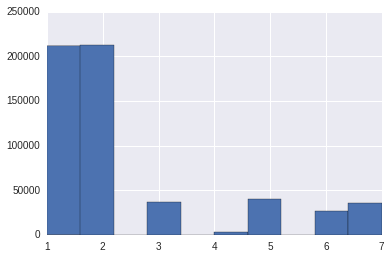

In [76]:
rf = RandomForestClassifier(n_estimators=25,min_samples_split=20)
print_out_kaggle_submission(rf,X,Y,test_data,test_ids)

Adding new features gave us a little dip in accuracy down to **69%**. Let's investigate the ranking of features based on the results of our Random Forest parameters to ensure that some of our engineered features are bringing value to the estimator.

###Feature Selection###
Let's fit our random forest model and use the feature importances parameter to investigate the top 25 features identified by our model.

In [13]:
# Set some variables to hold dev and training data;
N = X.shape[0]
dev_data, dev_labels = X[2*N/3:], Y[2*N/3:]
train_data, train_labels = X[:2*N/3], Y[:2*N/3]

#fit the model
features = df_train.columns
rf = RandomForestClassifier(n_estimators=25,min_samples_split=20)
rf.fit(train_data,train_labels)

#get the list of features ranked by importance
importances = zip(features,rf.feature_importances_)
importances.sort(key = lambda t: -1*t[1])
for feature,score in importances[:25]:
    print '%s: %s' % (feature,score)

Elevation: 0.180939769513
Horizontal_Distance_To_Roadways: 0.060275344364
climatic zone 8: 0.0476916251275
Horizontal_Distance_To_Fire_Points: 0.0457561350616
Wilderness_Area1: 0.0452684659066
Soil_Type1: 0.0406361805898
soil prefix 27: 0.0351901586368
Aspect: 0.0347759039947
Horizontal_Distance_To_Hydrology: 0.0337039727141
Hillshade_9am: 0.0333100139184
Hillshade_3pm: 0.0330513832417
geologic zone 7: 0.0282092882097
Vertical_Distance_To_Hydrology: 0.0277116104335
Hillshade_Noon: 0.0271340151324
subalpine zone: 0.0261318319595
Wilderness_Area4: 0.0228699842648
Slope: 0.0214004995605
climatic zone 7: 0.0211268000589
climatic zone 2: 0.0202290310445
Soil_Type4: 0.0199460451686
montane zone: 0.0197111147808
Wilderness_Area2: 0.015479877456
Aspect0_90: 0.0136856872407
Soil_Type11: 0.0125108865158
soil prefix 47: 0.0111963600731


We can see from the list of top 25 features identified by our random forest model that some of our engineered features are ranked highly in terms of information gain. For now we will keep our added features and see what sort of improvement we can get from tuning the model parameters further.

###Node Splitting###
The default setting of the sci-kit learn Random Forest model considers features up to the square root of the total number of features when determining which feature to split on. Let's instead consider a large number of values to use for our model to see if we can improve accuracy even further.

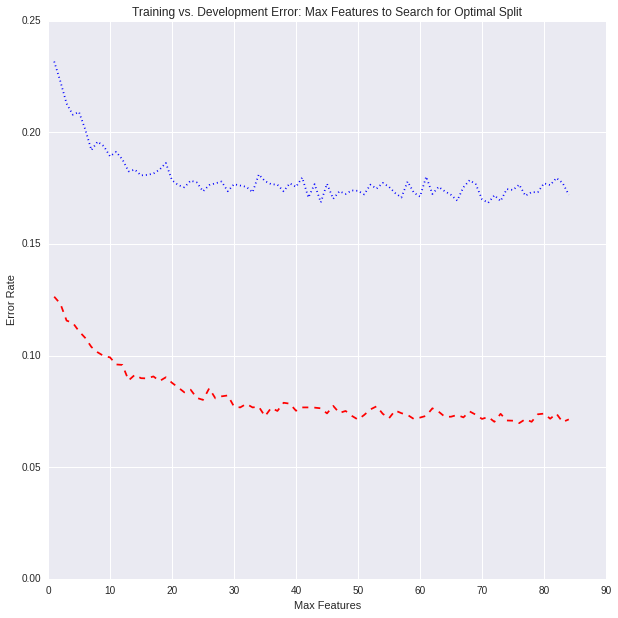

In [16]:
#iterate through several numbers of max features to search for a best split, 
#and plot the error rate of the training prediction vs. 
#the development prediction.
train_acc = []
dev_acc = []
for i in range(1,X.shape[1]):
    rf = RandomForestClassifier(n_estimators=25,min_samples_split=20,max_features=i)
    rf.fit(train_data,train_labels)
    train_acc.append(error_rate(rf,train_data,train_labels))
    dev_acc.append(error_rate(rf,dev_data,dev_labels))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(range(1,X.shape[1]),train_acc,'--',c='r')
ax.plot(range(1,X.shape[1]),dev_acc,':',c='b')
ax.set_ylim((0,.25))
ax.set_ylabel("Error Rate")
ax.set_xlabel("Max Features")
ax.set_title("Training vs. Development Error: Max Features to Search for Optimal Split")

The default sci-kit learn Random Forest max features parameter uses the square root of the feature size, however this chart shows that we will get better accuracy by considering all features per split.

In [81]:
#Let's check an anticipated accuracy using 5-fold cross-validation
rf = RandomForestClassifier(n_estimators=25,min_samples_split=20,max_features=None)
rf.fit(X,Y)
print 'Average accuracy: %s' % (np.mean(cross_val_score(rf,X,Y,cv=5))*100)

Average accuracy: 83.1878306878


Saved  565892 records to Submission.csv


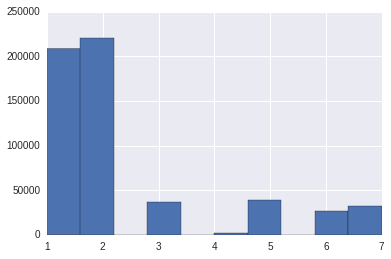

In [82]:
rf = RandomForestClassifier(n_estimators=25,min_samples_split=20,max_features=None)
print_out_kaggle_submission(rf,X,Y,test_data,test_ids)

By setting the random forest to search all features for splits we have gained another 1% accuracy in our model against the test set, up to **71.2%**.

###Target Weights###
Throughout this process we have run up against two challenges with the training and test data. First, our training data size is very small compared to the test data at 15k versus about 560k examples. Second, it can clearly be seen in the results of all of our models that the weights of targets in the test set are highly skewed whereas the training set has a perfect split of each tree type. 

In particular all of our models have predicted a significantly greater amount of tree types 1 and 2, however  the Random Forest model is being initialized with the default assumption that the weights of the targets are uniform as they are in our training data.

Let's try tweaking the initial target weights in our model based on weights identified by a different classifier, the K-Nearest Neighbor baseline model.

To get a better estimate of target weights in our test set we will fit a K-Nearest Neighbors model with our training data, then randomly sample the test data several times, predict the weights of the targets on the random subset, and use the average weights we find to fit a new Random Forest model.

In [18]:
#fit a baseline nearest-neighbors model
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X,Y)

#create a zero array to hold taret weights
weights = np.zeros(7)
test_dense = test_data.todense()
#iterate 5 times:
#extract a random subset of test data
#predict the KNN target value
#add the target weights to the weights array
for i in range(5):
    test_subset = test_dense[np.random.choice(test_dense.shape[0],10000)] #get a random 10000 example subset
    weights = weights + np.bincount(knn.predict(test_subset))[1:]
    
#create a target weights dictionary with the average predicted weights
weights = weights/5 #average weights
weight_dict = {i+1:weights[i]/np.sum(weights) for i in range(len(weights))} #dictionary of normalized average weights
print weights
print np.sum(weights)
print weight_dict
del test_dense

[ 3594.4  3777.8   614.     67.8   825.4   502.4   618.2]
10000.0
{1: 0.35943999999999993, 2: 0.37777999999999995, 3: 0.061399999999999989, 4: 0.0067799999999999987, 5: 0.082539999999999988, 6: 0.050239999999999986, 7: 0.061819999999999993}


In [19]:
#Let's check an anticipated accuracy using 5-fold cross-validation
rf = RandomForestClassifier(n_estimators=25,min_samples_split=20,max_features=None,class_weight=weight_dict)
rf.fit(X,Y)
print 'Average accuracy: %s' % (np.mean(cross_val_score(rf,X,Y,cv=5))*100)

Average accuracy: 80.8134920635


Saved  565892 records to Submission.csv


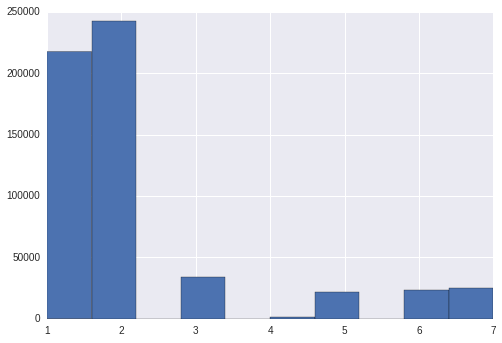

In [20]:
rf = RandomForestClassifier(n_estimators=25,min_samples_split=20,max_features=None,class_weight=weight_dict)
print_out_kaggle_submission(rf,X,Y,test_data,test_ids)

By fitting the model with a rough estimate of the target weights from the test set instead of the even weighting of the training set we see our accuracy on our training set go down, however we get a huge jump in accuracy against the Kaggle test set to **76.03%**.

This method has a risk of overfitting the test set so let's now implement the parameters we have tuned in a classic random forest to an ensemble method that is better suited to protect against over fitting: an Extra Trees Classifier.

###Extra Trees Classifier##

While extensive work was done with feature engineering for this project, we continued to research alternative ensemble or boosting methods for increasing the performance of decision trees.  In studying ensemble methods for decision trees to find suitable alternatives to random forests, we came across Extra Trees Classifier as a comparable  alternative at http://scikit-learn.org/stable/modules/ensemble.html.  Geurts et al. proposed this method in their paper at http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.7485&rep=rep1&type=pdf,  a tree ensemble method called “extra-trees”.  


This method is an considered to improve on random forests because unlike random forests which are grown with multiple subsets, the base trees of extra-trees are grown from the complete learning set and by explicitly randomizing the cut-points.  At each node, k randomly generated splits are created and the best amongst them is chosen.  While this leads to a slightly higher bias, it allows us to reduce the variance a little when compares to random forests.  This allows us to improve the predictive accuracy and control over-fitting.

In [21]:
#Let's check an anticipated accuracy using 5-fold cross-validation
et = ExtraTreesClassifier(n_estimators=25,min_samples_split=20,max_features=None,class_weight=weight_dict)
et.fit(X,Y)
print 'Average accuracy: %s' % (np.mean(cross_val_score(et,X,Y,cv=5))*100)

Average accuracy: 81.2037037037


Saved  565892 records to Submission.csv


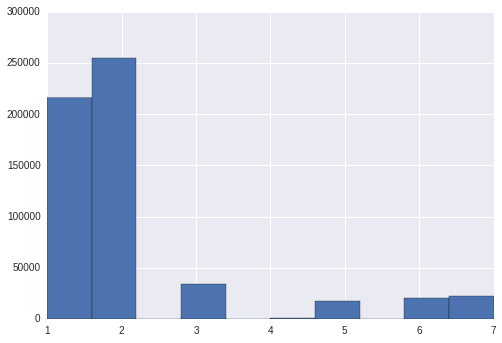

In [22]:
et = ExtraTreesClassifier(n_estimators=25,min_samples_split=20,max_features=None,class_weight=weight_dict)
print_out_kaggle_submission(et,X,Y,test_data,test_ids)

By using our tuned features and parameters with an Extra Trees Classifier we were able to increase accuracy yet again to **78.09%**.

Next let's investigate the conservative minimum samples parameter we tuned for our Random Forest. Perhaps we can relax some of the restriction for an Extra Trees classifier.

In [13]:
# Set some variables to hold dev and training data;
N = X.shape[0]
dev_data, dev_labels = X[2*N/3:], Y[2*N/3:]
train_data, train_labels = X[:2*N/3], Y[:2*N/3]

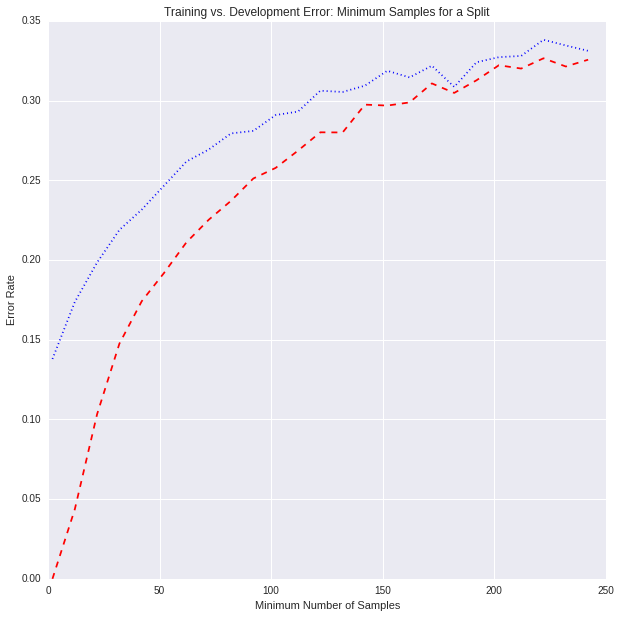

In [14]:
#iterate through several numbers of split parameters, 
#and plot the error rate of the training prediction vs. 
#the development prediction.

train_acc = []
dev_acc = []
for n in range(2,250,10):
    et = ExtraTreesClassifier(n_estimators=25,min_samples_split=n,max_features=None,class_weight=weight_dict)
    et.fit(train_data,train_labels)
    train_acc.append(error_rate(et,train_data,train_labels))
    dev_acc.append(error_rate(et,dev_data,dev_labels))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(range(2,250,10),train_acc,'--',c='r')
ax.plot(range(2,250,10),dev_acc,':',c='b')
ax.set_ylabel("Error Rate")
ax.set_xlabel("Minimum Number of Samples")
ax.set_title("Training vs. Development Error: Minimum Samples for a Split")


The variance in the Extra Trees model does appear to be lower than the Random Forest model. Let's lower the value of minimum samples from 20 to 15.

In [26]:
#Let's check an anticipated accuracy using 5-fold cross-validation
et = ExtraTreesClassifier(n_estimators=25,min_samples_split=15,max_features=None,class_weight=weight_dict)
et.fit(X,Y)
print 'Average accuracy: %s' % (np.mean(cross_val_score(et,X,Y,cv=5))*100)

Average accuracy: 82.7447089947


Saved  565892 records to Submission.csv


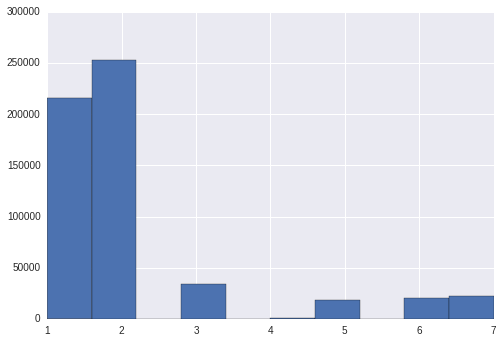

In [25]:
et = ExtraTreesClassifier(n_estimators=25,min_samples_split=15,max_features=None,class_weight=weight_dict)
print_out_kaggle_submission(et,X,Y,test_data,test_ids)

By tuning the minimum samples parameter for the Extra Trees classifier, which protects better for overfitting than the standard Random Forest, we have acheived an accuracy of **78.64%** against the Kaggle test set.

The Extra Trees Classifier has been proven to converge to an optimal solution with the number of estimators set to at least 100 trees. For our final run, let's max out the number of estimators as much as we can.

Saved  565892 records to Submission.csv


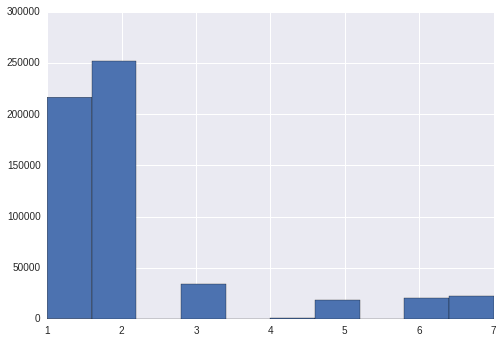

In [27]:
et = ExtraTreesClassifier(n_estimators=1500,min_samples_split=15,max_features=None,class_weight=weight_dict)
print_out_kaggle_submission(et,X,Y,test_data,test_ids)

This final run gave us accuracy of **78.97%** against the test set and a Kaggle rank of 258 out of 1695.

##Part 5. Final Results##

Below we list a final summary of the steps that we took and the accuracy we were able to obtain.

|  Step  |  Kaggle Accuracy  |  
|---|---|
|  1-Nearest Neighbor Baseline  |  71.06%  | 
|  Limit trees to 20 examples minimum for a node split  |  70.17%  |
|  Add new features and scale  |  69%  | 
|  Set trees to search all features for node split  |  71.2%  | 
|  Generate better estimate of target weights from KNN prediction on random draws from test set  |  76.03%  | 
|  Switch to Extra Trees Classifier  |  78.09%  | 
|  Relax minimum samples for node split requirement to 15  |  78.64%  | 
|  Use recommended minimum 1500 trees classifier for Extra Trees  |  78.97%  | 